# Net Surgery

Caffe networks can be transformed to your particular needs by editing the model parameters. The data, diffs, and parameters of a net are all exposed in pycaffe.

Roll up your sleeves for net surgery with pycaffe!

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import cPickle as pkl
import os
import pylab
import sys
import lmdb
import time
%matplotlib inline
#import Image

# Make sure that caffe is on the python path:
caffe_root = '../../caffe/'  # this file is expected to be in {caffe_root}/examples
import sys
sys.path.insert(0, caffe_root + 'python')

import caffe

# configure plotting
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Initial network

In [3]:
# Load the net, list its data and params, and filter an example image.
caffe.set_mode_gpu()
caffe.set_device(1)
net = caffe.Net('model_resnet101_t200/model_resnet101_deploy.prototxt', 'model_resnet101_t200/resnet101_snapshot_iter_25000.caffemodel', caffe.TEST)
print("blobs {}\nparams {}".format(net.blobs.keys(), net.params.keys()))



blobs ['data', 'conv1', 'pool1', 'pool1_pool1_0_split_0', 'pool1_pool1_0_split_1', 'res2a_branch1', 'res2a_branch2a', 'res2a_branch2b', 'res2a_branch2c', 'res2a', 'res2a_res2a_relu_0_split_0', 'res2a_res2a_relu_0_split_1', 'res2b_branch2a', 'res2b_branch2b', 'res2b_branch2c', 'res2b', 'res2b_res2b_relu_0_split_0', 'res2b_res2b_relu_0_split_1', 'res2c_branch2a', 'res2c_branch2b', 'res2c_branch2c', 'res2c', 'res2c_res2c_relu_0_split_0', 'res2c_res2c_relu_0_split_1', 'res3a_branch1', 'res3a_branch2a', 'res3a_branch2b', 'res3a_branch2c', 'res3a', 'res3a_res3a_relu_0_split_0', 'res3a_res3a_relu_0_split_1', 'res3b1_branch2a', 'res3b1_branch2b', 'res3b1_branch2c', 'res3b1', 'res3b1_res3b1_relu_0_split_0', 'res3b1_res3b1_relu_0_split_1', 'res3b2_branch2a', 'res3b2_branch2b', 'res3b2_branch2c', 'res3b2', 'res3b2_res3b2_relu_0_split_0', 'res3b2_res3b2_relu_0_split_1', 'res3b3_branch2a', 'res3b3_branch2b', 'res3b3_branch2c', 'res3b3', 'res3b3_res3b3_relu_0_split_0', 'res3b3_res3b3_relu_0_split_1'

## test network

In [12]:
net_model = 'model_vgg19_t200'
db = 'test'
with open('../code/nmf/coco/doc-topic_%s_t200.npy'%(db)) as f :
    nmf_result = np.load(f)
print(nmf_result.shape)
val_set = []
with open('../data/splits/kar_%s.ids'%(db)) as f:
    for line in f:
        val_set.append(int(line.strip()))

def print_top_words2(t_idx, components_, feature_names, n_top_words):
    for topic_idx in t_idx:
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in components_[topic_idx].argsort()[:-n_top_words - 1:-1]]))
    
with open('../code/nmf/coco/tfidf-nmf_t200.pkl') as f:
    tfidf, nmf = pkl.load(f)
    
np_pred = np.load('./%s/output/lmdb1_bak/%s_pred.npy'%(net_model, db))

print(np_pred.shape)

(5000, 200)
(5000, 200)


354533
(310, 640, 3)
(310, 640)
[ 28  41  43 119 139 152 155 169]
Topic #28:
motorcycl motor helmet bike motorcyclist cycl rider motorbik race biker scooter drive mope garag turn row track leather polic sidecar
Topic #41:
beach sand sandi shore near surfer seagul carri sun sunset day shorelin background loung fli sunni bikini enjoy lawn edg
Topic #43:
sheep lamb goat flock pastur pen herd hay anim farm grassi hillsid ram shear barn wool coupl togeth pet sheer
Topic #119:
lot mani bunch ha sever space clutter busi variou empti furnitur differ crowd park item veri vehicl surround thi big
Topic #139:
outsid store shop outdoor restaur patio yard talk cafe market day tent grill gather step area set door sell lawn
Topic #152:
park near curb van scooter area garag space motor row besid spot empti silver dock lot anoth cement mope gravel
Topic #155:
herd cattl river heard anim mani togeth bunch sever flock wild goat gather hole plain dri lush number pack stream
Topic #169:
dirt ground path bik

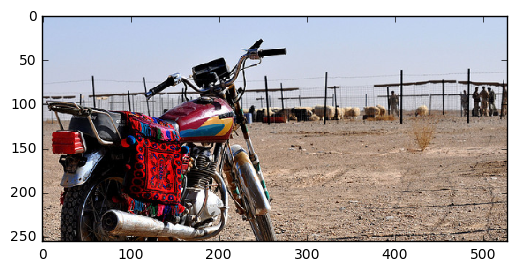

In [20]:
valimg_idx = 21
#8


topic_ids = np.arange(0, 200)
%matplotlib inline
img_id = val_set[valimg_idx]
print(img_id)
img_path = '../data/images/%02d/%d.jpg'%(img_id/10000, img_id)
img = cv2.imread(img_path)
print(img.shape)
min_l, max_l = min([img.shape[0], img.shape[1]]), max([img.shape[0], img.shape[1]])
print(min_l, max_l)
rescale_ratio = 256.0/min_l
img = cv2.resize(img, (int(img.shape[1]*rescale_ratio), int(img.shape[0]*rescale_ratio)))
plt.imshow(img[:,:,::-1])
t_idx = topic_ids[nmf_result[valimg_idx]>0.01]
print(t_idx)
print_top_words2(t_idx, nmf.components_, tfidf.get_feature_names(), 20)
'''
img = img[16:240,16:240].astype('float32') - np.array([103.939, 116.779, 123.68], dtype='float32')
img = img.transpose(2,0,1)
im_input = img[np.newaxis, :, :, :]
net.blobs['data'].reshape(*im_input.shape)
net.blobs['data'].data[...] = im_input
output = net.forward()
pred_top_indx = np.argsort(0 - output['pred'])[0]
'''
#print(np_pred[valimg_idx])
pred_top_indx = np.argsort(0 - np_pred[valimg_idx])
print(pred_top_indx)
print_top_words2(pred_top_indx[0:10].tolist(), nmf.components_, tfidf.get_feature_names(), 20)

## produce dataset

In [33]:
#dbs = ['test', 'val', 'train']
net_model = 'model_resnet101_t200'
dbs = ['test', 'val', 'train']
for db in dbs :
    np_db = []
    print('dataset:', db)
    img_set = []
    with open('../data/splits/kar_%s.ids'%(db)) as f:
        for line in f:
            img_set.append(int(line.strip()))

    for db_i in range(len(img_set)) :
        if db_i%1000 == 0 :
            print db_i, img_set[db_i]
        img_id = img_set[db_i]
        img_path = '../data/images/%02d/%d.jpg'%(img_id/10000, img_id)
        img = cv2.imread(img_path)
        min_l, max_l = min([img.shape[0], img.shape[1]]), max([img.shape[0], img.shape[1]])
        print(min_l, max_l)
        rescale_ratio = 256.0/min_l
        img = cv2.resize(img, (int(img.shape[1]*rescale_ratio), int(img.shape[0]*rescale_ratio)))

        img = img[16:240,16:240].astype('float32') - np.array([103.939, 116.779, 123.68], dtype='float32')
        img = img.transpose(2,0,1)
        im_input = img[np.newaxis, :, :, :]
        net.blobs['data'].reshape(*im_input.shape)
        net.blobs['data'].data[...] = im_input
        output = net.forward()
        pred = output['pred'][0].astype('float32')
        np_db.append(pred)
    np_db = np.array(np_db, dtype='float32')
    print(np_db.shape)
    with open('./%s/output/%s.npy'%(net_model, db), 'w') as f :
        np.save(f, np_db)

('dataset:', 'test')
0 391895
1000 53267
2000 354165
3000 566717
4000 82935
(5000, 100)
('dataset:', 'val')
0 184613
1000 126744
2000 541550
3000 481010
4000 167240
(5000, 100)
('dataset:', 'train')
0 522418
1000 173984
2000 51500
3000 286553
4000 130619
5000 210457
6000 564337
7000 225505
8000 107800
9000 17365
10000 303647
11000 472501
12000 111180
13000 510871
14000 382734
15000 250592
16000 393720
17000 175443
18000 25593
19000 15797
20000 551241
21000 573113
22000 41846
23000 412204
24000 191758
25000 517832
26000 461839
27000 305101
28000 92145
29000 138185
30000 296381
31000 260347
32000 57115
33000 550834
34000 177762
35000 306581
36000 536175
37000 67771
38000 84901
39000 488277
40000 308641
41000 518548
42000 242052
43000 517723
44000 3178
45000 182212
46000 61819
47000 400134
48000 202960
49000 123762
50000 200500
51000 144283
52000 256734
53000 358620
54000 369253
55000 244835
56000 128309
57000 285253
58000 344264
59000 244055
60000 176279
61000 419644
62000 340348
63000 4

In [10]:
net_model = 'model_resnet101_t200'
for db in ['test', 'val', 'train'] :
    lmdb_env = lmdb.open('%s_lmdb2'%(db))
    lmdb_txn = lmdb_env.begin()
    lmdb_cursor = lmdb_txn.cursor()
    datum = caffe.proto.caffe_pb2.Datum()

    def get_data_fromnet(im_input, net, preds, fc8s) :
        net.blobs['data'].reshape(*im_input.shape)
        net.blobs['data'].data[...] = im_input
        output = net.forward()
        preds += net.blobs['pred'].data[0]
        fc8s += net.blobs['fc7'].data[0]

        im_input = im_input[:, :, ::-1]
        net.blobs['data'].reshape(*im_input.shape)
        net.blobs['data'].data[...] = im_input
        output = net.forward()
        preds += net.blobs['pred'].data[0]
        fc8s += net.blobs['fc7'].data[0]

    pred_list = []
    fc7_list = []
    mean_values = np.array([103.939, 116.779, 123.68], dtype='float32')[:, np.newaxis, np.newaxis]
    img_num = 0
    begin_time = time.time()
    for key, value in lmdb_cursor:
        img_num += 1
        if img_num % 1000 == 0 :
            print img_num, (time.time() - begin_time)/60 , 'min'
            begin_time = time.time()
        datum.ParseFromString(value)
        label = datum.label
        data = caffe.io.datum_to_array(datum)
        data = data - mean_values
        im_input = np.zeros((1, 3, 224, 224))
        preds = np.zeros((100,))
        fc7s = np.zeros((4096,))
        im_input[:] = data[:, 0:224, 0:224]
        get_data_fromnet(im_input, net, preds, fc7s)
        im_input[:] = data[:, 0:224, -225:-1]
        get_data_fromnet(im_input, net, preds, fc7s)
        im_input[:] = data[:, -225:-1, 0:224]
        get_data_fromnet(im_input, net, preds, fc7s)
        im_input[:] = data[:, -225:-1, -225:-1]
        get_data_fromnet(im_input, net, preds, fc7s)
        im_input[:] = data[:, (data.shape[1]-224)/2:(data.shape[1]-224)/2+224, (data.shape[2]-224)/2:(data.shape[2]-224)/2+224]
        get_data_fromnet(im_input, net, preds, fc7s)
        pred_list.append(preds/10)
        fc7_list.append(fc7s/10)

    np_pred = np.array(pred_list, dtype='float32')
    print(np_pred.shape)
    with open('./%s/output/%s_pred.npy'%(net_model, db), 'w') as f :
        np.save(f, np_pred)
    np_fc7 = np.array(fc7_list, dtype='float32')
    print(np_fc7.shape)
    with open('./%s/output/%s_fc7.npy'%(net_model, db), 'w') as f :
        np.save(f, np_fc7)

(1, 3, 224, 224)


ValueError: operands could not be broadcast together with shapes (100,) (200,) (100,) 

In [12]:
net_model = 'model_resnet101_t200'

mean_datum = caffe.proto.caffe_pb2.BlobProto()
mean_datum.ParseFromString(open('model_resnet101_t200/ResNet_mean.binaryproto', 'rb').read())
img_mean = caffe.io.blobproto_to_array(mean_datum)
print(img_mean.shape)

datum = caffe.proto.caffe_pb2.Datum()
for db in ['test'] :
    lmdb_env = lmdb.open('%s_lmdb2'%(db))
    lmdb_txn = lmdb_env.begin()
    lmdb_cursor = lmdb_txn.cursor()

    def get_data_fromnet(im_input, net, preds, pool5) :
        im_input -= img_mean
        net.blobs['data'].reshape(*im_input.shape)
        net.blobs['data'].data[...] = im_input
        output = net.forward()
        preds += net.blobs['pred'].data[0]
        pool5 += net.blobs['pool5'].data[0,:,0,0]

        im_input = im_input[:, :, ::-1]
        net.blobs['data'].reshape(*im_input.shape)
        net.blobs['data'].data[...] = im_input
        output = net.forward()
        preds += net.blobs['pred'].data[0]
        pool5 += net.blobs['pool5'].data[0,:,0,0]

    pred_list = []
    pool5_list = []
    img_num = 0
    begin_time = time.time()
    for key, value in lmdb_cursor:
        img_num += 1
        if img_num % 1000 == 0 :
            print img_num, (time.time() - begin_time)/60 , 'min'
            begin_time = time.time()
        datum.ParseFromString(value)
        label = datum.label
        data = caffe.io.datum_to_array(datum)
        im_input = np.zeros((1, 3, 224, 224))
        preds = np.zeros((200,))
        pool5 = np.zeros((2048,))
        im_input[:] = data[:, 0:224, 0:224]
        get_data_fromnet(im_input, net, preds, pool5)
        im_input[:] = data[:, 0:224, -225:-1]
        get_data_fromnet(im_input, net, preds, pool5)
        im_input[:] = data[:, -225:-1, 0:224]
        get_data_fromnet(im_input, net, preds, pool5)
        im_input[:] = data[:, -225:-1, -225:-1]
        get_data_fromnet(im_input, net, preds, pool5)
        im_input[:] = data[:, (data.shape[1]-224)/2:(data.shape[1]-224)/2+224, (data.shape[2]-224)/2:(data.shape[2]-224)/2+224]
        get_data_fromnet(im_input, net, preds, pool5)
        pred_list.append(preds/10)
        pool5_list.append(pool5/10)

    np_pred = np.array(pred_list, dtype='float32')
    print(np_pred.shape)
    with open('./%s/output/%s_pred.npy'%(net_model, db), 'w') as f :
        np.save(f, np_pred)
    np_pool5 = np.array(pool5_list, dtype='float32')
    print(np_pool5.shape)
    with open('./%s/output/%s_pool5.npy'%(net_model, db), 'w') as f :
        np.save(f, np_pool5)

(1, 3, 224, 224)
1000 3.64221663475 min
2000 3.68184090058 min
3000 3.68612463077 min
4000 3.68737959862 min
5000 3.68569574753 min
(5000, 200)
(5000, 2048)


In [104]:
print(np_fc7[0].mean())

0.130787


## visual log

1251
1250
min loss : 6.00106 26 21


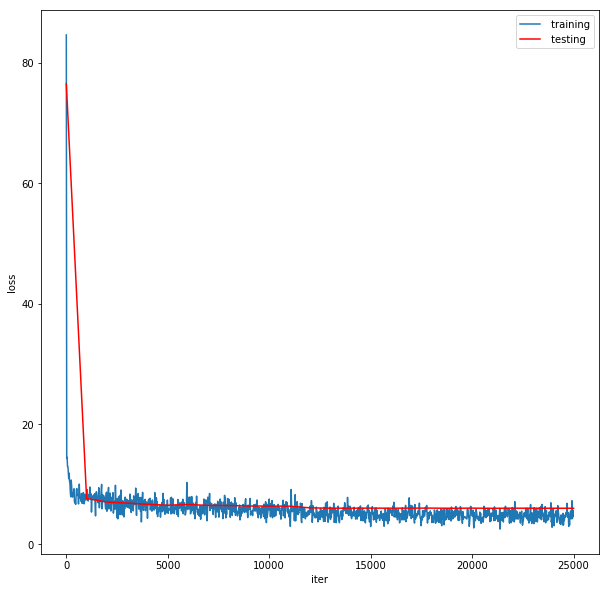

In [32]:
log_file = 'model2/log.txt'

train_iter = []
train_loss = []
test_iter = []
test_acc = []
test_loss = []

class CaffeVersion:
    OLD, NEW = range(0, 2)
CAFFE_VERSION = CaffeVersion.OLD

# prefix_loss = (CAFFE_VERSION is CaffeVersion.OLD) and 'loss = ' or 'loss_triplet = '
prefix_loss_tab = ['loss = ']
prefix_acc_tab  = ['accuracy = ']

base_train_iternum = 0
base_test_iternum = 0

prefix_iter = 'Iteration '
prefix_train_loss = 'Train net output #0: loss = '
prefix_test_loss = 'Test net output #0: loss = '

train_loss_dic = {}
test_loss_dic = {}
for prefix_loss in prefix_loss_tab:
    train_loss_dic[prefix_loss] = []
    test_loss_dic[prefix_loss] = []

with open(log_file) as f:
    for line in f:
        # itration
        if line.find(prefix_iter) >= 0:
            st = line.find(prefix_iter) + len(prefix_iter)
            ed = line.find(',')
            iter_num = int(line[st:ed])
            if line.find('Testing net') >= 0:
                if len(test_iter) > 0 and iter_num + base_test_iternum < test_iter[-1] :
                    base_test_iternum = test_iter[-1]
                test_iter.append(iter_num + base_test_iternum)
            else:
                if line.find('lr = ') < 0:
                    if len(train_iter) > 0 and iter_num + base_train_iternum < train_iter[-1] :
                        base_train_iternum = train_iter[-1]
                    train_iter.append(iter_num + base_train_iternum)
                    

        # train loss
        if line.find(prefix_train_loss) >= 0:
            st = line.find(prefix_train_loss) + len(prefix_train_loss)
            ed = line.find('(')
            train_loss.append(float(line[st:ed]))
            # print line[st:ed]
            continue
        # test loss
        if line.find(prefix_test_loss) >= 0:
            st = line.find(prefix_test_loss) + len(prefix_test_loss)
            ed = line.find('(')
            test_loss.append(float(line[st:ed]))
            # print line[st:ed]
            continue

print len(train_iter)
print len(train_loss)
diff = len(train_iter) - len(train_loss)
if diff != 0:
    train_iter = train_iter[:-diff]
print 'min loss :', np.min(test_loss), len(test_loss), np.argmin(test_loss)

pylab.figure()
pylab.plot(train_iter, train_loss)
pylab.plot(test_iter, test_loss, 'r')
pylab.legend([' training', ' testing'])
pylab.xlabel('iter'), pylab.ylabel('loss')

pylab.show()


In [28]:
    with open('./%s/output/%s.npy'%(net_model, 'xx'), 'w') as f :
        np.save(f, xx)
    print(np.sort(0 - xx[1]))

[ -9.98278022e-01  -8.06598186e-01  -1.67553663e-01  -1.60534352e-01
  -1.11096397e-01  -9.12671685e-02  -8.08769092e-02  -7.13539869e-02
  -6.64497986e-02  -3.24248411e-02  -1.43427458e-02  -1.33991567e-02
  -1.07431868e-02  -6.24432135e-03  -5.95308933e-03  -5.37698856e-03
  -4.98477183e-03  -4.54928307e-03  -4.51786164e-03  -4.49465076e-03
  -4.24010679e-03  -4.23246576e-03  -3.93398153e-03  -3.10178404e-03
  -1.64063985e-03  -1.51649956e-03  -1.49697333e-03  -1.48753228e-03
  -1.33748061e-03  -1.13000313e-03  -1.08417019e-03  -9.78396740e-04
  -9.15097480e-04  -9.00565472e-04  -8.74328602e-04  -8.64605710e-04
  -7.70958490e-04  -6.45101769e-04  -6.26840570e-04  -6.11028634e-04
  -5.95596095e-04  -5.15638094e-04  -5.04399417e-04  -4.83836600e-04
  -4.76727349e-04  -4.74222586e-04  -4.11018962e-04  -3.96963471e-04
  -3.70121677e-04  -3.52907809e-04  -3.30371869e-04  -3.26784851e-04
  -3.06291535e-04  -2.76506471e-04  -2.52763741e-04  -2.17960478e-04
  -2.10928090e-04  -2.09753460e-04

The convolution weights are initialized from Gaussian noise while the biases are initialized to zero. These random filters give output somewhat like edge detections.

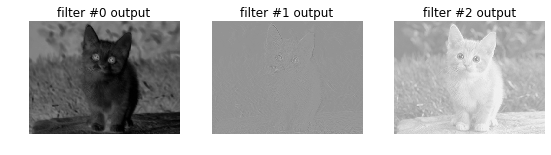

In [3]:
# helper show filter outputs
def show_filters(net):
    net.forward()
    plt.figure()
    filt_min, filt_max = net.blobs['conv'].data.min(), net.blobs['conv'].data.max()
    for i in range(3):
        plt.subplot(1,4,i+2)
        plt.title("filter #{} output".format(i))
        plt.imshow(net.blobs['conv'].data[0, i], vmin=filt_min, vmax=filt_max)
        plt.tight_layout()
        plt.axis('off')

# filter the image with initial 
show_filters(net)

Raising the bias of a filter will correspondingly raise its output:

In [4]:
# pick first filter output
conv0 = net.blobs['conv'].data[0, 0]
print("pre-surgery output mean {:.2f}".format(conv0.mean()))
# set first filter bias to 10
net.params['conv'][1].data[0] = 1.
net.forward()
print("post-surgery output mean {:.2f}".format(conv0.mean()))

pre-surgery output mean -12.93
post-surgery output mean -11.93


Altering the filter weights is more exciting since we can assign any kernel like Gaussian blur, the Sobel operator for edges, and so on. The following surgery turns the 0th filter into a Gaussian blur and the 1st and 2nd filters into the horizontal and vertical gradient parts of the Sobel operator.

See how the 0th output is blurred, the 1st picks up horizontal edges, and the 2nd picks up vertical edges.

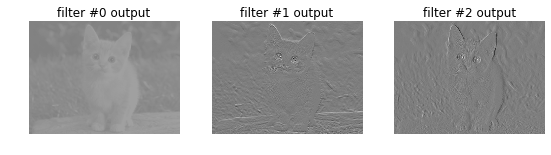

In [5]:
ksize = net.params['conv'][0].data.shape[2:]
# make Gaussian blur
sigma = 1.
y, x = np.mgrid[-ksize[0]//2 + 1:ksize[0]//2 + 1, -ksize[1]//2 + 1:ksize[1]//2 + 1]
g = np.exp(-((x**2 + y**2)/(2.0*sigma**2)))
gaussian = (g / g.sum()).astype(np.float32)
net.params['conv'][0].data[0] = gaussian
# make Sobel operator for edge detection
net.params['conv'][0].data[1:] = 0.
sobel = np.array((-1, -2, -1, 0, 0, 0, 1, 2, 1), dtype=np.float32).reshape((3,3))
net.params['conv'][0].data[1, 0, 1:-1, 1:-1] = sobel  # horizontal
net.params['conv'][0].data[2, 0, 1:-1, 1:-1] = sobel.T  # vertical
show_filters(net)

With net surgery, parameters can be transplanted across nets, regularized by custom per-parameter operations, and transformed according to your schemes.

## Casting a Classifier into a Fully Convolutional Network

Let's take the standard Caffe Reference ImageNet model "CaffeNet" and transform it into a fully convolutional net for efficient, dense inference on large inputs. This model generates a classification map that covers a given input size instead of a single classification. In particular a 8 $\times$ 8 classification map on a 451 $\times$ 451 input gives 64x the output in only 3x the time. The computation exploits a natural efficiency of convolutional network (convnet) structure by amortizing the computation of overlapping receptive fields.

To do so we translate the `InnerProduct` matrix multiplication layers of CaffeNet into `Convolutional` layers. This is the only change: the other layer types are agnostic to spatial size. Convolution is translation-invariant, activations are elementwise operations, and so on. The `fc6` inner product when carried out as convolution by `fc6-conv` turns into a 6 \times 6 filter with stride 1 on `pool5`. Back in image space this gives a classification for each 227 $\times$ 227 box with stride 32 in pixels. Remember the equation for output map / receptive field size, output = (input - kernel_size) / stride + 1, and work out the indexing details for a clear understanding.

In [6]:
!diff imagenet/bvlc_caffenet_full_conv.prototxt ../models/bvlc_reference_caffenet/deploy.prototxt

diff: imagenet/bvlc_caffenet_full_conv.prototxt: No such file or directory


The only differences needed in the architecture are to change the fully connected classifier inner product layers into convolutional layers with the right filter size -- 6 x 6, since the reference model classifiers take the 36 elements of `pool5` as input -- and stride 1 for dense classification. Note that the layers are renamed so that Caffe does not try to blindly load the old parameters when it maps layer names to the pretrained model.

In [7]:
# Make sure that caffe is on the python path:
caffe_root = '../'  # this file is expected to be in {caffe_root}/examples
import sys
sys.path.insert(0, caffe_root + 'python')

import caffe

# Load the original network and extract the fully connected layers' parameters.
net = caffe.Net('../models/bvlc_reference_caffenet/deploy.prototxt', 
                '../models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel', 
                caffe.TEST)
params = ['fc6', 'fc7', 'fc8']
# fc_params = {name: (weights, biases)}
fc_params = {pr: (net.params[pr][0].data, net.params[pr][1].data) for pr in params}

for fc in params:
    print '{} weights are {} dimensional and biases are {} dimensional'.format(fc, fc_params[fc][0].shape, fc_params[fc][1].shape)

fc6 weights are (4096, 9216) dimensional and biases are (4096,) dimensional
fc7 weights are (4096, 4096) dimensional and biases are (4096,) dimensional
fc8 weights are (1000, 4096) dimensional and biases are (1000,) dimensional


Consider the shapes of the inner product parameters. The weight dimensions are the output and input sizes while the bias dimension is the output size.

In [8]:
# Load the fully convolutional network to transplant the parameters.
net_full_conv = caffe.Net('net_surgery/bvlc_caffenet_full_conv.prototxt', 
                          '../models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel',
                          caffe.TEST)
params_full_conv = ['fc6-conv', 'fc7-conv', 'fc8-conv']
# conv_params = {name: (weights, biases)}
conv_params = {pr: (net_full_conv.params[pr][0].data, net_full_conv.params[pr][1].data) for pr in params_full_conv}

for conv in params_full_conv:
    print '{} weights are {} dimensional and biases are {} dimensional'.format(conv, conv_params[conv][0].shape, conv_params[conv][1].shape)

fc6-conv weights are (4096, 256, 6, 6) dimensional and biases are (4096,) dimensional
fc7-conv weights are (4096, 4096, 1, 1) dimensional and biases are (4096,) dimensional
fc8-conv weights are (1000, 4096, 1, 1) dimensional and biases are (1000,) dimensional


The convolution weights are arranged in output $\times$ input $\times$ height $\times$ width dimensions. To map the inner product weights to convolution filters, we could roll the flat inner product vectors into channel $\times$ height $\times$ width filter matrices, but actually these are identical in memory (as row major arrays) so we can assign them directly.

The biases are identical to those of the inner product.

Let's transplant!

In [9]:
for pr, pr_conv in zip(params, params_full_conv):
    conv_params[pr_conv][0].flat = fc_params[pr][0].flat  # flat unrolls the arrays
    conv_params[pr_conv][1][...] = fc_params[pr][1]

Next, save the new model weights.

In [10]:
net_full_conv.save('net_surgery/bvlc_caffenet_full_conv.caffemodel')

To conclude, let's make a classification map from the example cat image and visualize the confidence of "tiger cat" as a probability heatmap. This gives an 8-by-8 prediction on overlapping regions of the 451 $\times$ 451 input.

[[282 282 281 281 281 281 277 282]
 [281 283 283 281 281 281 281 282]
 [283 283 283 283 283 283 287 282]
 [283 283 283 281 283 283 283 259]
 [283 283 283 283 283 283 283 259]
 [283 283 283 283 283 283 259 259]
 [283 283 283 283 259 259 259 277]
 [335 335 283 259 263 263 263 277]]


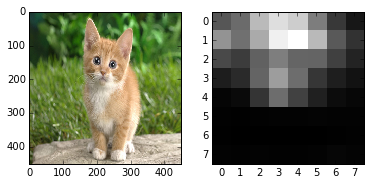

In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# load input and configure preprocessing
im = caffe.io.load_image('images/cat.jpg')
transformer = caffe.io.Transformer({'data': net_full_conv.blobs['data'].data.shape})
transformer.set_mean('data', np.load('../python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1))
transformer.set_transpose('data', (2,0,1))
transformer.set_channel_swap('data', (2,1,0))
transformer.set_raw_scale('data', 255.0)
# make classification map by forward and print prediction indices at each location
out = net_full_conv.forward_all(data=np.asarray([transformer.preprocess('data', im)]))
print out['prob'][0].argmax(axis=0)
# show net input and confidence map (probability of the top prediction at each location)
plt.subplot(1, 2, 1)
plt.imshow(transformer.deprocess('data', net_full_conv.blobs['data'].data[0]))
plt.subplot(1, 2, 2)
plt.imshow(out['prob'][0,281])

The classifications include various cats -- 282 = tiger cat, 281 = tabby, 283 = persian -- and foxes and other mammals.

In this way the fully connected layers can be extracted as dense features across an image (see `net_full_conv.blobs['fc6'].data` for instance), which is perhaps more useful than the classification map itself.

Note that this model isn't totally appropriate for sliding-window detection since it was trained for whole-image classification. Nevertheless it can work just fine. Sliding-window training and finetuning can be done by defining a sliding-window ground truth and loss such that a loss map is made for every location and solving as usual. (This is an exercise for the reader.)

*A thank you to Rowland Depp for first suggesting this trick.*